In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    print(fc1.shape)
    
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 3*4*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([3*4*64, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 18290.099609, Accuracy = 0.00800000037998
Performance on test set: Training epochs #1000, Batch Loss = 12677.7773438, Accuracy = 0.0
Training epochs #20000: Batch Loss = 14243.214844, Accuracy = 0.0120000010356
Performance on test set: Training epochs #20000, Batch Loss = 9512.55761719, Accuracy = 0.0
Training epochs #40000: Batch Loss = 6735.645996, Accuracy = 0.0389999970794
Performance on test set: Training epochs #40000, Batch Loss = 4494.30517578, Accuracy = 0.0
Training epochs #60000: Batch Loss = 3580.147949, Accuracy = 0.224000006914
Performance on test set: Training epochs #60000, Batch Loss = 509.412567139, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 2021.378906, Accuracy = 0.504999995232
Performance on test set: Training epochs #80000, Batch Loss = 824.812683105, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 9770.969727, Accuracy = 0.0410000011325
Performance on test set: Training epochs #100000, Batch 

Training epochs #920000: Batch Loss = 749.740540, Accuracy = 0.656999945641
Performance on test set: Training epochs #920000, Batch Loss = 119.069831848, Accuracy = 0.943000018597
Training epochs #940000: Batch Loss = 486.206787, Accuracy = 0.782000005245
Performance on test set: Training epochs #940000, Batch Loss = 190.031494141, Accuracy = 0.943000018597
Training epochs #960000: Batch Loss = 385.678436, Accuracy = 0.847000002861
Performance on test set: Training epochs #960000, Batch Loss = 226.427429199, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 3215.993652, Accuracy = 0.208000004292
Performance on test set: Training epochs #980000, Batch Loss = 114.347251892, Accuracy = 0.942999958992
Training epochs #1000000: Batch Loss = 716.177795, Accuracy = 0.650999963284
Performance on test set: Training epochs #1000000, Batch Loss = 109.125244141, Accuracy = 0.943000078201
Training epochs #1020000: Batch Loss = 420.653046, Accuracy = 0.818000018597
Performance on test 

Training epochs #1840000: Batch Loss = 186.505203, Accuracy = 0.885000109673
Performance on test set: Training epochs #1840000, Batch Loss = 127.061553955, Accuracy = 0.954999983311
Training epochs #1860000: Batch Loss = 1973.884766, Accuracy = 0.293999999762
Performance on test set: Training epochs #1860000, Batch Loss = 69.0508651733, Accuracy = 0.954999983311
Training epochs #1880000: Batch Loss = 452.247223, Accuracy = 0.726000010967
Performance on test set: Training epochs #1880000, Batch Loss = 67.9902267456, Accuracy = 0.955000042915
Training epochs #1900000: Batch Loss = 231.331406, Accuracy = 0.847999989986
Performance on test set: Training epochs #1900000, Batch Loss = 105.320350647, Accuracy = 0.954999983311
Training epochs #1920000: Batch Loss = 157.273315, Accuracy = 0.911000013351
Performance on test set: Training epochs #1920000, Batch Loss = 125.505203247, Accuracy = 0.955000042915
Training epochs #1940000: Batch Loss = 1877.721313, Accuracy = 0.317000001669
Performance

Training epochs #2760000: Batch Loss = 255.068665, Accuracy = 0.787999987602
Performance on test set: Training epochs #2760000, Batch Loss = 45.0515975952, Accuracy = 0.961000025272
Training epochs #2780000: Batch Loss = 191.067825, Accuracy = 0.864000082016
Performance on test set: Training epochs #2780000, Batch Loss = 66.7258758545, Accuracy = 0.955000042915
Training epochs #2800000: Batch Loss = 104.125854, Accuracy = 0.9240000844
Performance on test set: Training epochs #2800000, Batch Loss = 79.8730697632, Accuracy = 0.955000042915
Training epochs #2820000: Batch Loss = 1332.060791, Accuracy = 0.376000016928
Performance on test set: Training epochs #2820000, Batch Loss = 42.3434715271, Accuracy = 0.961000025272
Training epochs #2840000: Batch Loss = 226.503174, Accuracy = 0.800999999046
Performance on test set: Training epochs #2840000, Batch Loss = 43.2202606201, Accuracy = 0.961000025272
Training epochs #2860000: Batch Loss = 174.357910, Accuracy = 0.878000020981
Performance on

Training epochs #3680000: Batch Loss = 85.306740, Accuracy = 0.942000031471
Performance on test set: Training epochs #3680000, Batch Loss = 49.3411598206, Accuracy = 0.961000025272
Training epochs #3700000: Batch Loss = 928.844910, Accuracy = 0.456999987364
Performance on test set: Training epochs #3700000, Batch Loss = 27.9090213776, Accuracy = 0.961000025272
Training epochs #3720000: Batch Loss = 172.875732, Accuracy = 0.819999992847
Performance on test set: Training epochs #3720000, Batch Loss = 29.5206890106, Accuracy = 0.967999994755
Training epochs #3740000: Batch Loss = 129.313553, Accuracy = 0.898999989033
Performance on test set: Training epochs #3740000, Batch Loss = 42.032409668, Accuracy = 0.961000025272
Training epochs #3760000: Batch Loss = 65.428741, Accuracy = 0.935000121593
Performance on test set: Training epochs #3760000, Batch Loss = 47.5065498352, Accuracy = 0.961000025272
Training epochs #3780000: Batch Loss = 871.896179, Accuracy = 0.454999983311
Performance on t

Training epochs #4600000: Batch Loss = 95.179962, Accuracy = 0.888000011444
Performance on test set: Training epochs #4600000, Batch Loss = 17.9652328491, Accuracy = 0.969000041485
Training epochs #4620000: Batch Loss = 76.708061, Accuracy = 0.914000034332
Performance on test set: Training epochs #4620000, Batch Loss = 27.9477519989, Accuracy = 0.968000054359
Training epochs #4640000: Batch Loss = 51.078411, Accuracy = 0.949000000954
Performance on test set: Training epochs #4640000, Batch Loss = 31.3382148743, Accuracy = 0.961000025272
Training epochs #4660000: Batch Loss = 606.906860, Accuracy = 0.532000005245
Performance on test set: Training epochs #4660000, Batch Loss = 13.8249902725, Accuracy = 0.982000112534
Training epochs #4680000: Batch Loss = 90.555191, Accuracy = 0.877000033855
Performance on test set: Training epochs #4680000, Batch Loss = 17.2727394104, Accuracy = 0.96899998188
Training epochs #4700000: Batch Loss = 75.918121, Accuracy = 0.92300003767
Performance on test 

Training epochs #5520000: Batch Loss = 36.051762, Accuracy = 0.956000089645
Performance on test set: Training epochs #5520000, Batch Loss = 18.0930423737, Accuracy = 0.968000054359
Training epochs #5540000: Batch Loss = 413.430176, Accuracy = 0.602999985218
Performance on test set: Training epochs #5540000, Batch Loss = 9.76154232025, Accuracy = 0.983000040054
Training epochs #5560000: Batch Loss = 56.363396, Accuracy = 0.915000021458
Performance on test set: Training epochs #5560000, Batch Loss = 9.9192276001, Accuracy = 0.989999949932
Training epochs #5580000: Batch Loss = 38.575539, Accuracy = 0.947000026703
Performance on test set: Training epochs #5580000, Batch Loss = 16.2976665497, Accuracy = 0.96899998188
Training epochs #5600000: Batch Loss = 15.253659, Accuracy = 0.971000015736
Performance on test set: Training epochs #5600000, Batch Loss = 16.7774677277, Accuracy = 0.967999994755
Training epochs #5620000: Batch Loss = 443.809723, Accuracy = 0.583999991417
Performance on test

Training epochs #6440000: Batch Loss = 39.622551, Accuracy = 0.944000005722
Performance on test set: Training epochs #6440000, Batch Loss = 8.28024864197, Accuracy = 0.991000056267
Training epochs #6460000: Batch Loss = 29.707336, Accuracy = 0.957000076771
Performance on test set: Training epochs #6460000, Batch Loss = 7.98201131821, Accuracy = 0.975999951363
Training epochs #6480000: Batch Loss = 21.795105, Accuracy = 0.965000033379
Performance on test set: Training epochs #6480000, Batch Loss = 6.74838733673, Accuracy = 0.96899998188
Training epochs #6500000: Batch Loss = 299.428711, Accuracy = 0.633000016212
Performance on test set: Training epochs #6500000, Batch Loss = 8.40774822235, Accuracy = 0.990000128746
Training epochs #6520000: Batch Loss = 33.595558, Accuracy = 0.94000017643
Performance on test set: Training epochs #6520000, Batch Loss = 8.72307395935, Accuracy = 0.991000056267
Training epochs #6540000: Batch Loss = 29.933451, Accuracy = 0.955000042915
Performance on test 

Training epochs #7360000: Batch Loss = 13.734917, Accuracy = 0.973000049591
Performance on test set: Training epochs #7360000, Batch Loss = 5.10027360916, Accuracy = 0.990000128746
Training epochs #7380000: Batch Loss = 254.560089, Accuracy = 0.675999999046
Performance on test set: Training epochs #7380000, Batch Loss = 6.79307079315, Accuracy = 0.991000056267
Training epochs #7400000: Batch Loss = 25.820200, Accuracy = 0.947000086308
Performance on test set: Training epochs #7400000, Batch Loss = 6.93873500824, Accuracy = 0.991000056267
Training epochs #7420000: Batch Loss = 25.491928, Accuracy = 0.957000076771
Performance on test set: Training epochs #7420000, Batch Loss = 5.52232265472, Accuracy = 0.991000115871
Training epochs #7440000: Batch Loss = 15.840599, Accuracy = 0.969000041485
Performance on test set: Training epochs #7440000, Batch Loss = 4.85341215134, Accuracy = 0.990000128746
Training epochs #7460000: Batch Loss = 223.332458, Accuracy = 0.713000059128
Performance on te

Training epochs #8280000: Batch Loss = 17.193050, Accuracy = 0.962999999523
Performance on test set: Training epochs #8280000, Batch Loss = 5.54526329041, Accuracy = 0.991000056267
Training epochs #8300000: Batch Loss = 11.618505, Accuracy = 0.97000002861
Performance on test set: Training epochs #8300000, Batch Loss = 4.17204236984, Accuracy = 0.991000056267
Training epochs #8320000: Batch Loss = 7.614595, Accuracy = 0.981000006199
Performance on test set: Training epochs #8320000, Batch Loss = 3.59871292114, Accuracy = 0.991000056267
Training epochs #8340000: Batch Loss = 155.723770, Accuracy = 0.745000004768
Performance on test set: Training epochs #8340000, Batch Loss = 5.43255662918, Accuracy = 0.991000056267
Training epochs #8360000: Batch Loss = 17.685366, Accuracy = 0.963000059128
Performance on test set: Training epochs #8360000, Batch Loss = 5.44023275375, Accuracy = 0.991000056267
Training epochs #8380000: Batch Loss = 12.796100, Accuracy = 0.967000007629
Performance on test 

Training epochs #9200000: Batch Loss = 3.827454, Accuracy = 0.991999924183
Performance on test set: Training epochs #9200000, Batch Loss = 2.23253536224, Accuracy = 0.991000056267
Training epochs #9220000: Batch Loss = 119.696198, Accuracy = 0.759999990463
Performance on test set: Training epochs #9220000, Batch Loss = 3.84341740608, Accuracy = 0.991000056267
Training epochs #9240000: Batch Loss = 11.463778, Accuracy = 0.979000091553
Performance on test set: Training epochs #9240000, Batch Loss = 3.95454120636, Accuracy = 0.991000056267
Training epochs #9260000: Batch Loss = 10.619964, Accuracy = 0.976999998093
Performance on test set: Training epochs #9260000, Batch Loss = 2.72705435753, Accuracy = 0.991000056267
Training epochs #9280000: Batch Loss = 3.876196, Accuracy = 0.987000048161
Performance on test set: Training epochs #9280000, Batch Loss = 2.32099103928, Accuracy = 0.991000056267
Training epochs #9300000: Batch Loss = 141.270142, Accuracy = 0.743000030518
Performance on test

Training epochs #10120000: Batch Loss = 7.029877, Accuracy = 0.979000031948
Performance on test set: Training epochs #10120000, Batch Loss = 2.61600494385, Accuracy = 0.991000056267
Training epochs #10140000: Batch Loss = 4.692585, Accuracy = 0.981999993324
Performance on test set: Training epochs #10140000, Batch Loss = 1.36139583588, Accuracy = 0.991000056267
Training epochs #10160000: Batch Loss = 4.558611, Accuracy = 0.989000022411
Performance on test set: Training epochs #10160000, Batch Loss = 0.901561737061, Accuracy = 0.991000056267
Training epochs #10180000: Batch Loss = 88.908386, Accuracy = 0.792999982834
Performance on test set: Training epochs #10180000, Batch Loss = 2.81942796707, Accuracy = 0.991000056267
Training epochs #10200000: Batch Loss = 8.949499, Accuracy = 0.976999998093
Performance on test set: Training epochs #10200000, Batch Loss = 2.78335976601, Accuracy = 0.991000056267
Training epochs #10220000: Batch Loss = 9.716648, Accuracy = 0.984000086784
Performance 

Training epochs #11020000: Batch Loss = 2.307842, Accuracy = 0.990000009537
Performance on test set: Training epochs #11020000, Batch Loss = 1.01317679882, Accuracy = 0.991000056267
Training epochs #11040000: Batch Loss = 0.991091, Accuracy = 0.990000009537
Performance on test set: Training epochs #11040000, Batch Loss = 0.4629342556, Accuracy = 0.991000056267
Training epochs #11060000: Batch Loss = 67.658958, Accuracy = 0.818000018597
Performance on test set: Training epochs #11060000, Batch Loss = 1.69377207756, Accuracy = 0.990999996662
Training epochs #11080000: Batch Loss = 2.898318, Accuracy = 0.988000035286
Performance on test set: Training epochs #11080000, Batch Loss = 1.70846915245, Accuracy = 0.991000056267
Training epochs #11100000: Batch Loss = 2.709164, Accuracy = 0.991999983788
Performance on test set: Training epochs #11100000, Batch Loss = 0.445052504539, Accuracy = 0.990999937057
Training epochs #11120000: Batch Loss = 2.039459, Accuracy = 0.994000017643
Performance o

Training epochs #11920000: Batch Loss = 1.817191, Accuracy = 0.993000030518
Performance on test set: Training epochs #11920000, Batch Loss = 1.07288344875e-09, Accuracy = 1.00000011921
Training epochs #11940000: Batch Loss = 48.455643, Accuracy = 0.847999930382
Performance on test set: Training epochs #11940000, Batch Loss = 0.790308058262, Accuracy = 0.991000056267
Training epochs #11960000: Batch Loss = 1.376998, Accuracy = 0.991999924183
Performance on test set: Training epochs #11960000, Batch Loss = 0.689393043518, Accuracy = 0.991000056267
Training epochs #11980000: Batch Loss = 4.110482, Accuracy = 0.989000022411
Performance on test set: Training epochs #11980000, Batch Loss = 0.00720266718417, Accuracy = 0.996999979019
Training epochs #12000000: Batch Loss = 2.075862, Accuracy = 0.990999937057
Performance on test set: Training epochs #12000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12020000: Batch Loss = 51.468159, Accuracy = 0.847999989986
Performance on 

Training epochs #12840000: Batch Loss = 1.961657, Accuracy = 0.987000048161
Performance on test set: Training epochs #12840000, Batch Loss = 0.371504604816, Accuracy = 0.990999996662
Training epochs #12860000: Batch Loss = 1.880675, Accuracy = 0.989000082016
Performance on test set: Training epochs #12860000, Batch Loss = 0.0510054081678, Accuracy = 0.996999979019
Training epochs #12880000: Batch Loss = 0.847095, Accuracy = 0.998000025749
Performance on test set: Training epochs #12880000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12900000: Batch Loss = 36.020313, Accuracy = 0.865000009537
Performance on test set: Training epochs #12900000, Batch Loss = 0.562412261963, Accuracy = 0.996999979019
Training epochs #12920000: Batch Loss = 1.286365, Accuracy = 0.987999975681
Performance on test set: Training epochs #12920000, Batch Loss = 0.399201929569, Accuracy = 0.996999979019
Training epochs #12940000: Batch Loss = 1.232541, Accuracy = 0.993000090122
Performance on test

Training epochs #13780000: Batch Loss = 28.261766, Accuracy = 0.863000035286
Performance on test set: Training epochs #13780000, Batch Loss = 0.284927606583, Accuracy = 0.997000098228
Training epochs #13800000: Batch Loss = 1.144080, Accuracy = 0.994000017643
Performance on test set: Training epochs #13800000, Batch Loss = 0.11190097779, Accuracy = 0.997000098228
Training epochs #13820000: Batch Loss = 2.776949, Accuracy = 0.990000009537
Performance on test set: Training epochs #13820000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13840000: Batch Loss = 0.503283, Accuracy = 0.997000098228
Performance on test set: Training epochs #13840000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13860000: Batch Loss = 20.754078, Accuracy = 0.898000061512
Performance on test set: Training epochs #13860000, Batch Loss = 0.205101579428, Accuracy = 0.997000098228
Training epochs #13880000: Batch Loss = 0.685191, Accuracy = 0.994000077248
Performance on test set: Trainin

Training epochs #14720000: Batch Loss = 0.193041, Accuracy = 0.995999932289
Performance on test set: Training epochs #14720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14740000: Batch Loss = 11.204401, Accuracy = 0.920000076294
Performance on test set: Training epochs #14740000, Batch Loss = 0.0219607278705, Accuracy = 0.996999979019
Training epochs #14760000: Batch Loss = 0.812938, Accuracy = 0.992000102997
Performance on test set: Training epochs #14760000, Batch Loss = 0.0678326115012, Accuracy = 0.997000098228
Training epochs #14780000: Batch Loss = 0.917921, Accuracy = 0.993999958038
Performance on test set: Training epochs #14780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14800000: Batch Loss = 0.363652, Accuracy = 0.996000051498
Performance on test set: Training epochs #14800000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14820000: Batch Loss = 15.062123, Accuracy = 0.927999973297
Performance on test set: Training epochs 

Training epochs #15660000: Batch Loss = 0.907240, Accuracy = 0.992000043392
Performance on test set: Training epochs #15660000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15680000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15680000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15700000: Batch Loss = 11.298435, Accuracy = 0.925999999046
Performance on test set: Training epochs #15700000, Batch Loss = 0.0556765198708, Accuracy = 0.996999979019
Training epochs #15720000: Batch Loss = 0.699914, Accuracy = 0.992999970913
Performance on test set: Training epochs #15720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15740000: Batch Loss = 0.383928, Accuracy = 0.995000004768
Performance on test set: Training epochs #15740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15760000: Batch Loss = 0.059413, Accuracy = 0.999000072479
Performance on test set: Training epochs #15760000, Batc

# performance visualization

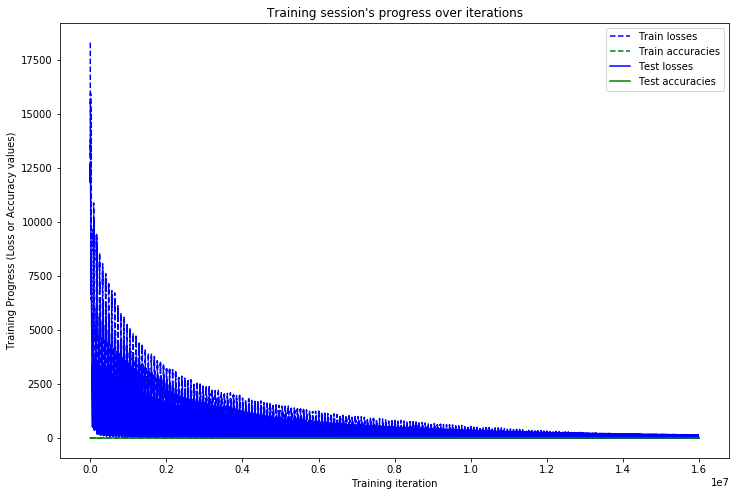

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.2336511681%
Recall: 97.065%
f1_score: 96.9868706702%

Confusion Matrix:
[[    0    18     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   826     0     0    27    45     4     0     0     0     0     9
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    52     0     0  2794     0     0    10     0     0     0    35
      0]
 [    0    71     0     0     0   274     0     0     0     0     0     3
      0]
 [    0     9     0     0     0     0 14486     0     0     0     0     0
      0]
 [    0   103     0     0    34    39     0   334     8     0     0    17
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     2     0     0
      0]
 [    0     0     0     0     0     0     0  

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


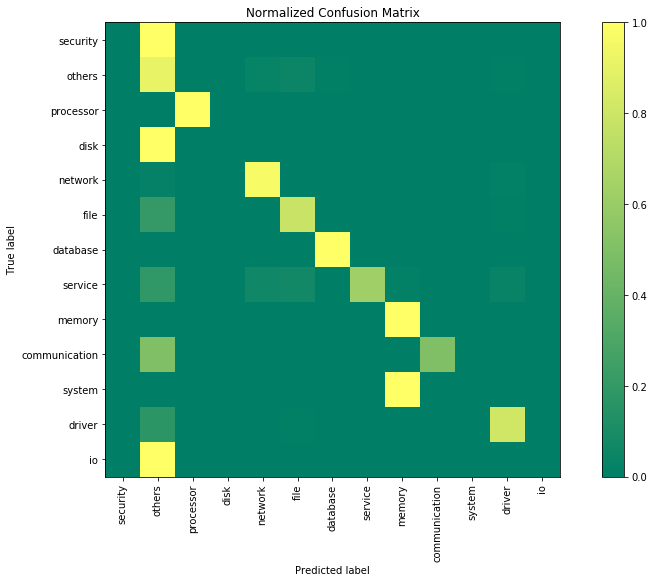

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)